# ***搭建RNN网络和LSTM网络***

# 0. 要解决的问题

① 循环神经网络（RNN）对于自然语言处理和其他序列任务非常有效，因为它们具有“记忆”功能。 

② 它们可以一次读取一个输入$x^{\langle t \rangle}$（例如单词），并且通过隐藏层激活从一个时间步传递到下一个时间步来记住一些信息/上下文，这允许单向RNN从过去获取信息来处理后面的输入，双向RNN可以从过去和未来中获取上下文。

③ 符号：

 - 上标$[l]$表示表示第$l$层
    - 例如：$a^{[4]}$表示第4层的激活值。$W^{[5]}$和$b^{[5]}$是第5层的参数。

 - 上标$(i)$表示第$i$个样本
    - 示例：$x^{(i)}$表示第$i$个输入的样本。

 - 上标$\langle t \rangle$表示第$t$个时间步
    - 示例：$x^{\langle t \rangle}$表示输入x的第$t$个时间步，$x^{(i)\langle t \rangle}$表示输入x的第i个样本的第t个时间步。

 - 下标$i$表示向量的第$i$项
    - 示例：$a^{[l]}_i$表示$l$层中的第$i$个项的激活值。

# 1. 导入库

In [1]:
import numpy as np
import rnn_utils

# 2. 循环神经网络的正向传播

① 我们来看一下下面的循环神经网络的图，在这里使用的是$T_x = T_y$，我们来实现它。

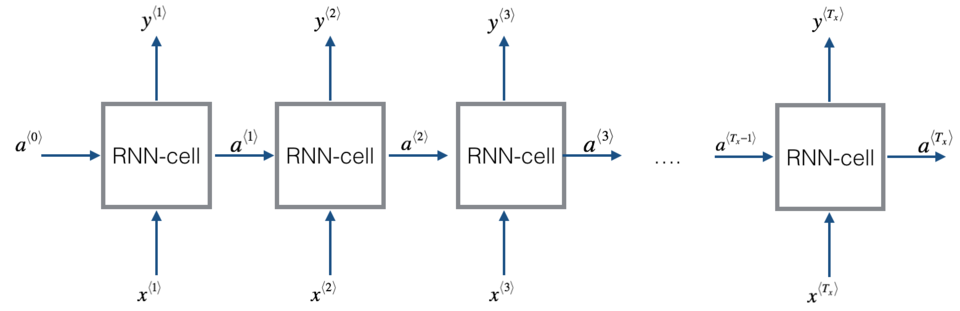

<center>图1 ：基础RNN模型</center>

② 实现RNN的方法，步骤：

 - 实现RNN的一个时间步所需的计算。
 - 在$T_x$个时间步上实现循环，以便一次处理所有输入。

## 2.1 RNN基本单元

① 循环神经网络可以看作是单元的重复，首先要实现单个时间步的计算，下图描述了RNN单元的单个时间步的操作。

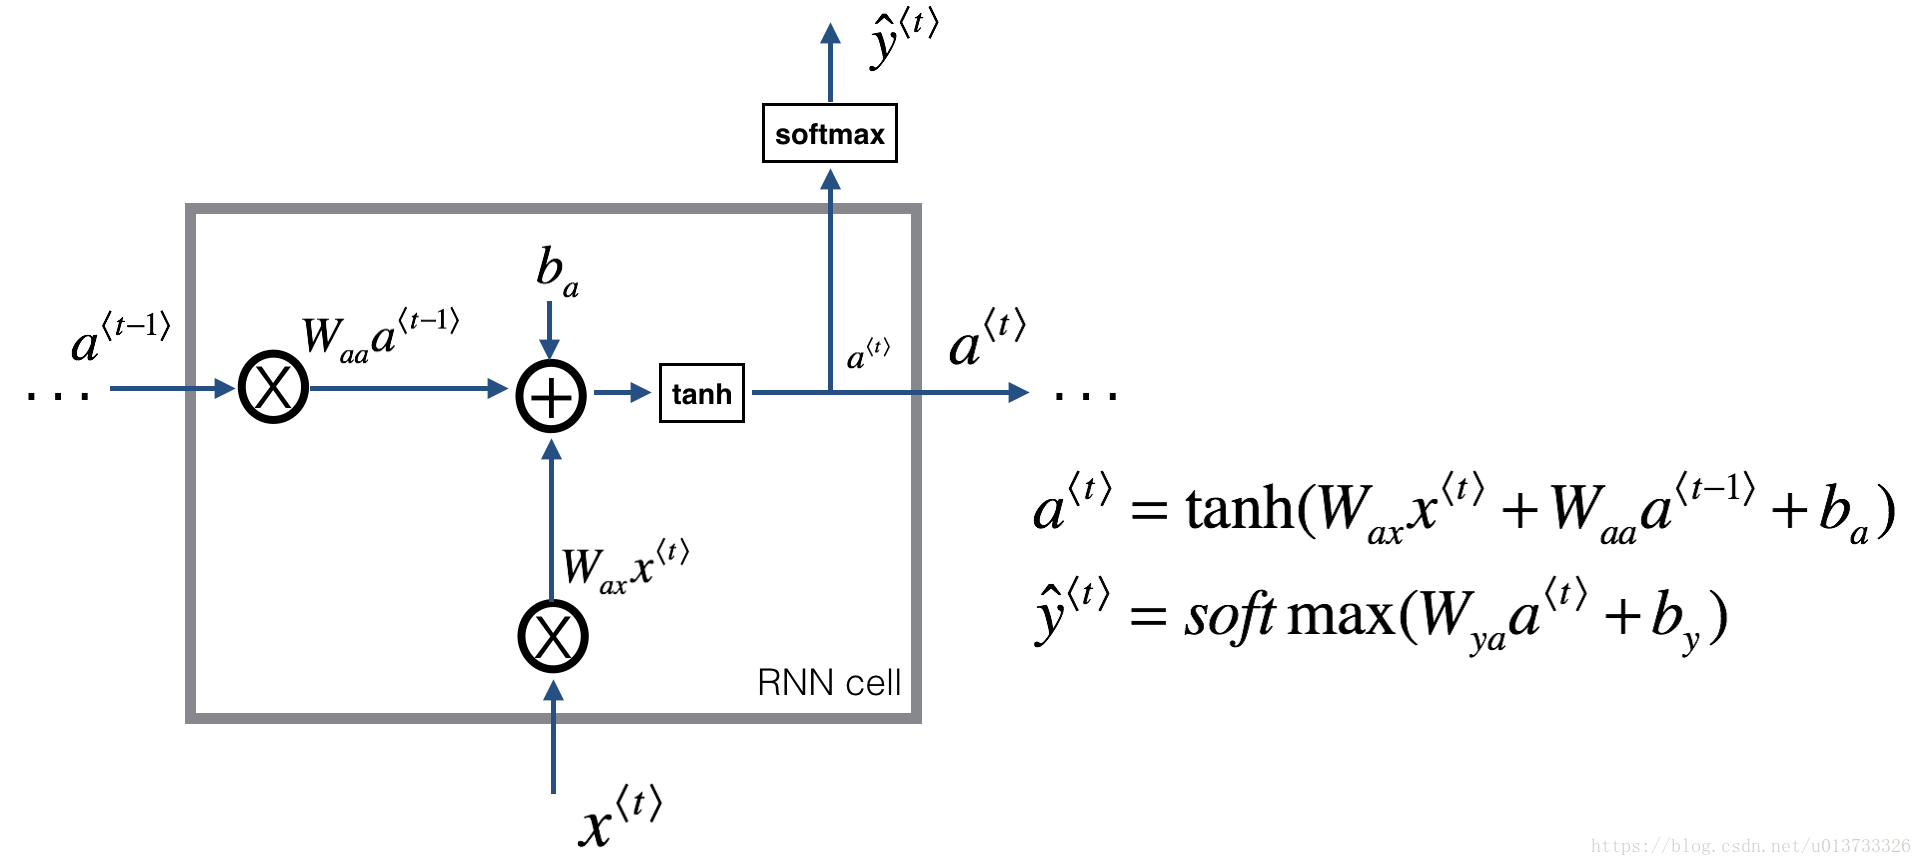

<center>图2: 基本的RNN单元</center>

② 将$x^{\langle t \rangle}$(当前输入)与$a^{\langle t - 1\rangle}$ (包含过去信息的上一隐藏层的激活值)作为输入，输出$a^{\langle t \rangle}$给下一个RNN单元，用于预测$y^{\langle t \rangle}$。

③ 现在我们要根据图2来实现一个RNN单元，这需要由以下几步完成：
 1. 使用tanh激活计算隐藏状态：$a^{\langle t \rangle} = \tanh(W_{aa} a^{\langle t-1 \rangle} + W_{ax} x^{\langle t \rangle} + b_a)$。
 2. 使用新的隐藏状态$a^{\langle t \rangle}$，计算预测$\hat{y}^{\langle t \rangle} = softmax(W_{ya} a^{\langle t \rangle} + b_y)$。我们为你提供了一个函数：softmax。
 3. 将$(a^{\langle t \rangle}, a^{\langle t-1 \rangle}, x^{\langle t \rangle}, parameters)$存储在缓存中。
 4. 返回$a^{\langle t \rangle}$，$y^{\langle t \rangle}$并缓存。

④ 我们将对m个示例进行向量化处理。因此，$x^{\langle t \rangle}$维度将是$(n_x,m)$，而$a^{\langle t \rangle}$维度将是$(n_a,m)$。

In [2]:
def rnn_cell_forward(xt, a_prev, parameters):
    """
    根据图2实现RNN单元的单步前向传播
    
    参数：
        xt -- 时间步“t”输入的数据，维度为（n_x, m）
        a_prev -- 时间步“t - 1”的隐藏隐藏状态，维度为（n_a, m）
        parameters -- 字典，包含了以下内容:
                        Wax -- 矩阵，输入乘以权重，维度为（n_a, n_x）
                        Waa -- 矩阵，隐藏状态乘以权重，维度为（n_a, n_a）
                        Wya -- 矩阵，隐藏状态与输出相关的权重矩阵，维度为（n_y, n_a）
                        ba  -- 偏置，维度为（n_a, 1）
                        by  -- 偏置，隐藏状态与输出相关的偏置，维度为（n_y, 1）
    
    返回：
        a_next -- 下一个隐藏状态，维度为（n_a， m）
        yt_pred -- 在时间步“t”的预测，维度为（n_y， m）
        cache -- 反向传播需要的元组，包含了(a_next, a_prev, xt, parameters)
    """
    
    # 从“parameters”获取参数
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    # 使用上面的公式计算下一个激活值
    a_next = np.tanh(np.dot(Waa, a_prev) + np.dot(Wax, xt) + ba)
    
    # 使用上面的公式计算当前单元的输出
    yt_pred = rnn_utils.softmax(np.dot(Wya, a_next) + by)
    
    # 保存反向传播需要的值
    cache = (a_next, a_prev, xt, parameters)
    
    return a_next, yt_pred, cache

In [3]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
Waa = np.random.randn(5,5)
Wax = np.random.randn(5,3)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Waa": Waa, "Wax": Wax, "Wya": Wya, "ba": ba, "by": by}

a_next, yt_pred, cache = rnn_cell_forward(xt, a_prev, parameters)
print("a_next[4] = ", a_next[4])
print("a_next.shape = ", a_next.shape)
print("yt_pred[1] =", yt_pred[1])
print("yt_pred.shape = ", yt_pred.shape)

a_next[4] =  [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
a_next.shape =  (5, 10)
yt_pred[1] = [0.9888161  0.01682021 0.21140899 0.36817467 0.98988387 0.88945212
 0.36920224 0.9966312  0.9982559  0.17746526]
yt_pred.shape =  (2, 10)


## 2.2 RNN正向传播

① 你可以将RNN视为刚刚构建的单元的重复。

 - 如果输入的数据序列经过10个时间步长，则将复制RNN单元10次。

② 每个单元格都将前一个单元格($a^{\langle t-1 \rangle}$)的隐藏状态和当前时间步的输入数据($x^{\langle t \rangle}$)作为输入，并为此时间步输出隐藏状态($a^{\langle t \rangle}$) 和预测($y^{\langle t \rangle}$)。

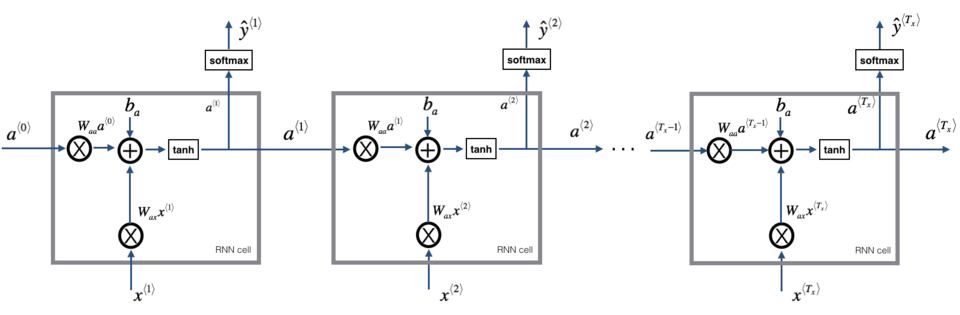

<center>图3：基本RNN</center>

③ 输入序列$x = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$执行$T_x$个时间步。网络输出$y = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$。

④ 我们要根据图3来实现前向传播的代码，它由以下几步构成：

 1. 创建0向量zeros(a)，它将保存RNN计算的所有的隐藏状态。
 2. 使用“$a_0$”初始化“next”隐藏状态。
 3. 循环所有时间步：
   - 使用rnn_cell_forward函数来更新“next”隐藏状态与cache。
   - 使用a来保存“next”隐藏状态（第t）个位置。
   - 使用y来保存预测值。
   - 把cache保存到“caches”列表中。
 4. 返回a, y,与caches。

In [4]:
def rnn_forward(x, a0, parameters):
    """
    根据图3来实现循环神经网络的前向传播
    
    参数：
        x -- 输入的全部数据，维度为(n_x, m, T_x)
        a0 -- 初始化隐藏状态，维度为 (n_a, m)
        parameters -- 字典，包含了以下内容:
                        Wax -- 矩阵，输入乘以权重，维度为（n_a, n_x）
                        Waa -- 矩阵，隐藏状态乘以权重，维度为（n_a, n_a）
                        Wya -- 矩阵，隐藏状态与输出相关的权重矩阵，维度为（n_y, n_a）
                        ba  -- 偏置，维度为（n_a, 1）
                        by  -- 偏置，隐藏状态与输出相关的偏置，维度为（n_y, 1）
    
    返回：
        a -- 所有时间步的隐藏状态，维度为(n_a, m, T_x)
        y_pred -- 所有时间步的预测，维度为(n_y, m, T_x)
        caches -- 为反向传播的保存的元组，维度为（【列表类型】cache, x)）
    """
    
    # 初始化“caches”，它将以列表类型包含所有的cache
    caches = []
    
    # 获取 x 与 Wya 的维度信息
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wya"].shape
    
    # 使用0来初始化“a” 与“y”
    a = np.zeros([n_a, m, T_x])
    y_pred = np.zeros([n_y, m, T_x])
    
    # 初始化“next”
    a_next = a0
    
    # 遍历所有时间步
    for t in range(T_x):
        ## 1.使用rnn_cell_forward函数来更新“next”隐藏状态与cache。
        a_next, yt_pred, cache = rnn_cell_forward(x[:, :, t], a_next, parameters)
        
        ## 2.使用 a 来保存“next”隐藏状态（第 t ）个位置。
        a[:, :, t] = a_next
        
        ## 3.使用 y 来保存预测值。
        y_pred[:, :, t] = yt_pred
        
        ## 4.把cache保存到“caches”列表中。
        caches.append(cache)
    
    # 保存反向传播所需要的参数
    caches = (caches, x)
    
    return a, y_pred, caches

In [5]:
np.random.seed(1)
x = np.random.randn(3,10,4)
a0 = np.random.randn(5,10)
Waa = np.random.randn(5,5)
Wax = np.random.randn(5,3)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Waa": Waa, "Wax": Wax, "Wya": Wya, "ba": ba, "by": by}

a, y_pred, caches = rnn_forward(x, a0, parameters)
print("a[4][1] = ", a[4][1])
print("a.shape = ", a.shape)
print("y_pred[1][3] =", y_pred[1][3])
print("y_pred.shape = ", y_pred.shape)
print("caches[1][1][3] =", caches[1][1][3])
print("len(caches) = ", len(caches))

a[4][1] =  [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape =  (5, 10, 4)
y_pred[1][3] = [0.79560373 0.86224861 0.11118257 0.81515947]
y_pred.shape =  (2, 10, 4)
caches[1][1][3] = [-1.1425182  -0.34934272 -0.20889423  0.58662319]
len(caches) =  2


① Nice！你已经从头实现了循环神经网络的正向传播。对于某些应用来说，这已经足够好，但是会遇到梯度消失的问题。

② 当每个输出$y^{⟨t⟩}$是根据局部的上下文来进行预测的时候，它的效果是比较好的（意思是输入的是$x^{⟨t'⟩}$，其中$t'$与$t$相隔不是太远）。

③ 在下一部分中，你将构建一个更复杂的LSTM模型，该模型更适合解决逐渐消失的梯度。LSTM将能够更好地记住一条信息并将其保存许多个时间步。

# 3. 长短期记忆网络的正向传播

① 下图显示了LSTM单元的运作。

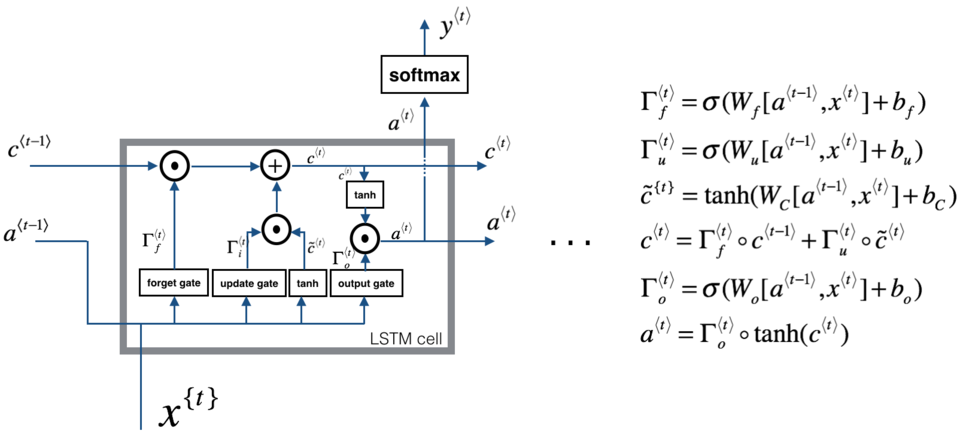

<center>图4：LSTM单元</center>

② 这会在每个时间步上跟踪并更新“单元状态”或记忆变量$c^{\langle t \rangle}$，这与$a^{\langle t \rangle}$不同。

③ 与上面的RNN示例类似，你将以单个时间步开始实现LSTM单元。然后，你可以从for循环内部迭代调用它，以使其具有$T_x$时间步长的输入。

## 3.1 关于“门”

### 3.1.1 遗忘门

① 假设我们正在阅读文本中的单词，并希望使用LSTM来跟踪语法结构，比如主语是单数还是复数。

② 如果主语从单数变为复数，我们需要找到一种方法来摆脱我们先前存储的单复数状态的记忆值。

③ 在LSTM中，遗忘门是这样做的:

$$\Gamma_f^{\langle t \rangle} = \sigma(W_f[a^{\langle t-1 \rangle}, x^{\langle t \rangle}] + b_f)\tag{1}$$

④ 在这里，$W_f$是控制遗忘门行为的权重。我们将$[a^{\langle t-1 \rangle}, x^{\langle t \rangle}]$连接起来，然后乘以$W_f$。

⑤ 上面的等式使得向量$\Gamma_f^{\langle t \rangle}$的值介于0到1之间。

⑥ 该遗忘门向量将与前一个单元状态$c^{\langle t-1 \rangle}$相乘。因此，如果$\Gamma_f^{\langle t \rangle}$的其中一个值为0（或接近于0），则表示LSTM应该移除$c^{\langle t-1 \rangle}$组件中的一部分信息（例如，单数主题），如果其中一个值为1，则它将保留信息。

### 3.1.2 更新门

① 一旦我们忘记了所讨论的主体是单数，就需要找到一种更新它的方式，以反映新主体现在是复数。

② 这是更新门的公式：

$$\Gamma_u^{\langle t \rangle} = \sigma(W_u[a^{\langle t-1 \rangle}, x^{\{t\}}] + b_u)\tag{2}$$

③ 类似于遗忘门，在这里$\Gamma_u^{\langle t \rangle}$也是值为0到1之间的向量。这将与$\tilde{c}^{\langle t \rangle}$逐元素相乘以计算$c^{\langle t \rangle}$。
 - 两个c不同，前面一个c上面有一横线，因为与下面的c挨得太紧，所有看着不明显。

### 3.1.3 更新单元

① 要更新新主体，我们需要创建一个新的数字向量，我们可以将其添加到之前的单元状态中。

② 我们使用的公式是：

$$\tilde{c}^{\langle t \rangle} = \tanh(W_c[a^{\langle t-1 \rangle}, x^{\langle t \rangle}] + b_c)\tag{3}$$

③ 最后，单元的新状态为：

$$c^{\langle t \rangle} = \Gamma_f^{\langle t \rangle}* c^{\langle t-1 \rangle} + \Gamma_u^{\langle t \rangle} *\tilde{c}^{\langle t \rangle} \tag{4}$$

### 3.1.4 输出门

① 为了确定我们将使用哪些输出，我们将使用以下两个公式：

$$\Gamma_o^{\langle t \rangle}=  \sigma(W_o[a^{\langle t-1 \rangle}, x^{\langle t \rangle}] + b_o)\tag{5}$$

$$a^{\langle t \rangle} = \Gamma_o^{\langle t \rangle}* \tanh(c^{\langle t \rangle})\tag{6}$$

② 在等式5中，你决定使用sigmoid函数输出；在等式6中，将其乘以先前状态的tanh。

## 3.2 LSTM基本单元

① 我们根据图4来实现一个LSTM单元，步骤如下：

 1. 将$a^{\langle t-1 \rangle}$和$x^{\langle t \rangle}$连接在一个矩阵中：$concat = \begin{bmatrix} a^{\langle t-1 \rangle} \\ x^{\langle t \rangle} \end{bmatrix}$
 2. 计算公式1-6，你可以使用sigmoid()和np.tanh()。
 3. 计算预测$y^{\langle t \rangle}$，你可以使用softmax()。

In [6]:
def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    根据图4实现一个LSTM单元的前向传播。
    
    参数：
        xt -- 在时间步“t”输入的数据，维度为(n_x, m)
        a_prev -- 上一个时间步“t-1”的隐藏状态，维度为(n_a, m)
        c_prev -- 上一个时间步“t-1”的记忆状态，维度为(n_a, m)
        parameters -- 字典类型的变量，包含了：
                        Wf -- 遗忘门的权值，维度为(n_a, n_a + n_x)
                        bf -- 遗忘门的偏置，维度为(n_a, 1)
                        Wi -- 更新门的权值，维度为(n_a, n_a + n_x)
                        bi -- 更新门的偏置，维度为(n_a, 1)
                        Wc -- 第一个“tanh”的权值，维度为(n_a, n_a + n_x)
                        bc -- 第一个“tanh”的偏置，维度为(n_a, n_a + n_x)
                        Wo -- 输出门的权值，维度为(n_a, n_a + n_x)
                        bo -- 输出门的偏置，维度为(n_a, 1)
                        Wy -- 隐藏状态与输出相关的权值，维度为(n_y, n_a)
                        by -- 隐藏状态与输出相关的偏置，维度为(n_y, 1)
    返回：
        a_next -- 下一个隐藏状态，维度为(n_a, m)
        c_next -- 下一个记忆状态，维度为(n_a, m)
        yt_pred -- 在时间步“t”的预测，维度为(n_y, m)
        cache -- 包含了反向传播所需要的参数，包含了(a_next, c_next, a_prev, c_prev, xt, parameters)
        
    注意：
        ft/it/ot表示遗忘/更新/输出门，cct表示候选值(c tilda)，c表示记忆值。
    """
    
    # 从“parameters”中获取相关值
    Wf = parameters["Wf"]
    bf = parameters["bf"]
    Wi = parameters["Wi"]
    bi = parameters["bi"]
    Wc = parameters["Wc"]
    bc = parameters["bc"]
    Wo = parameters["Wo"]
    bo = parameters["bo"]
    Wy = parameters["Wy"]
    by = parameters["by"]
    
    # 获取 xt 与 Wy 的维度信息
    n_x, m = xt.shape
    n_y, n_a = Wy.shape
    
    # 1.连接 a_prev 与 xt
    contact = np.zeros([n_a + n_x, m])
    contact[: n_a, :] = a_prev
    contact[n_a :, :] = xt
    
    # 2.根据公式计算ft、it、cct、c_next、ot、a_next
    
    ## 遗忘门，公式1
    ft = rnn_utils.sigmoid(np.dot(Wf, contact) + bf)
    
    ## 更新门，公式2
    it = rnn_utils.sigmoid(np.dot(Wi, contact) + bi)
    
    ## 更新单元，公式3
    cct = np.tanh(np.dot(Wc, contact) + bc)
    
    ## 更新单元，公式4
    #c_next = np.multiply(ft, c_prev) + np.multiply(it, cct)
    c_next = ft * c_prev + it * cct
    ## 输出门，公式5
    ot = rnn_utils.sigmoid(np.dot(Wo, contact) + bo)
    
    ## 输出门，公式6
    #a_next = np.multiply(ot, np.tan(c_next))
    a_next = ot * np.tanh(c_next)
    # 3.计算LSTM单元的预测值
    yt_pred = rnn_utils.softmax(np.dot(Wy, a_next) + by)
    
    # 保存包含了反向传播所需要的参数
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)
    
    return a_next, c_next, yt_pred, cache

In [7]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
c_prev = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a_next, c_next, yt, cache = lstm_cell_forward(xt, a_prev, c_prev, parameters)
print("a_next[4] = ", a_next[4])
print("a_next.shape = ", c_next.shape)
print("c_next[2] = ", c_next[2])
print("c_next.shape = ", c_next.shape)
print("yt[1] =", yt[1])
print("yt.shape = ", yt.shape)
print("cache[1][3] =", cache[1][3])
print("len(cache) = ", len(cache))

a_next[4] =  [-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]
a_next.shape =  (5, 10)
c_next[2] =  [ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]
c_next.shape =  (5, 10)
yt[1] = [0.79913913 0.15986619 0.22412122 0.15606108 0.97057211 0.31146381
 0.00943007 0.12666353 0.39380172 0.07828381]
yt.shape =  (2, 10)
cache[1][3] = [-0.16263996  1.03729328  0.72938082 -0.54101719  0.02752074 -0.30821874
  0.07651101 -1.03752894  1.41219977 -0.37647422]
len(cache) =  10


## 3.3 LSTM正向传播

① 既然你已经实现了LSTM的一个步骤，现在就可以使用for循环在$T_x$输入序列上对此进行迭代。

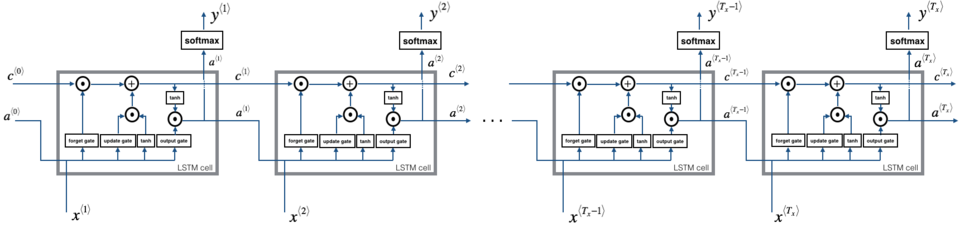

<center>图5: 多个时间步的LSTM的计算</center>

② 我们来实现lstm_forward()，然后运行$T_x$个时间步。

③ 注意：$c^{\langle 0 \rangle}$使用0来初始化。

In [8]:
def lstm_forward(x, a0, parameters):
    """
    根据图5来实现LSTM单元组成的的循环神经网络
    
    参数：
        x -- 所有时间步的输入数据，维度为(n_x, m, T_x)
        a0 -- 初始化隐藏状态，维度为(n_a, m)
        parameters -- python字典，包含了以下参数：
                        Wf -- 遗忘门的权值，维度为(n_a, n_a + n_x)
                        bf -- 遗忘门的偏置，维度为(n_a, 1)
                        Wi -- 更新门的权值，维度为(n_a, n_a + n_x)
                        bi -- 更新门的偏置，维度为(n_a, 1)
                        Wc -- 第一个“tanh”的权值，维度为(n_a, n_a + n_x)
                        bc -- 第一个“tanh”的偏置，维度为(n_a, n_a + n_x)
                        Wo -- 输出门的权值，维度为(n_a, n_a + n_x)
                        bo -- 输出门的偏置，维度为(n_a, 1)
                        Wy -- 隐藏状态与输出相关的权值，维度为(n_y, n_a)
                        by -- 隐藏状态与输出相关的偏置，维度为(n_y, 1)
        
    返回：
        a -- 所有时间步的隐藏状态，维度为(n_a, m, T_x)
        y -- 所有时间步的预测值，维度为(n_y, m, T_x)
        caches -- 为反向传播的保存的元组，维度为（【列表类型】cache, x)）
    """
    
    # 初始化“caches”
    caches = []
    
    # 获取 xt 与 Wy 的维度信息
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wy"].shape
    
    # 使用0来初始化“a”、“c”、“y”
    a = np.zeros([n_a, m, T_x])
    c = np.zeros([n_a, m, T_x])
    y = np.zeros([n_y, m, T_x])
    
    # 初始化“a_next”、“c_next”
    a_next = a0
    c_next = np.zeros([n_a, m])
    
    # 遍历所有的时间步
    for t in range(T_x):
        # 更新下一个隐藏状态，下一个记忆状态，计算预测值，获取cache
        a_next, c_next, yt_pred, cache = lstm_cell_forward(x[:,:,t], a_next, c_next, parameters)
        
        # 保存新的下一个隐藏状态到变量a中
        a[:, :, t] = a_next
        
        # 保存预测值到变量y中
        y[:, :, t] = yt_pred
        
        # 保存下一个单元状态到变量c中
        c[:, :, t] = c_next
        
        # 把cache添加到caches中
        caches.append(cache)
    
    # 保存反向传播需要的参数
    caches = (caches, x)
    
    return a, y, c, caches


In [9]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters)
print("a[4][3][6] = ", a[4][3][6])
print("a.shape = ", a.shape)
print("y[1][4][3] =", y[1][4][3])
print("y.shape = ", y.shape)
print("caches[1][1[1]] =", caches[1][1][1])
print("c[1][2][1]", c[1][2][1])
print("len(caches) = ", len(caches))


a[4][3][6] =  0.17211776753291672
a.shape =  (5, 10, 7)
y[1][4][3] = 0.9508734618501101
y.shape =  (2, 10, 7)
caches[1][1[1]] = [ 0.82797464  0.23009474  0.76201118 -0.22232814 -0.20075807  0.18656139
  0.41005165]
c[1][2][1] -0.8555449167181981
len(caches) =  2


# 4. 循环神经网络中的反向传播

① 在现代深度学习框架中，你仅需实现正向传播，而框架将处理反向传播，因此大多数深度学习工程师无需理会反向传播的细节。

② 但是，如果你是微积分专家并且想查看RNN中反向传播的详细信息，则可以学习此笔记本的剩余部分。

③ 在较早的课程中，当你实现了一个简单的（全连接的）神经网络时，你就使用了反向传播来计算用于更新参数的损失的导数。

④ 同样，在循环神经网络中，你可以计算损失的导数以更新参数。

⑤ 反向传播方程非常复杂，我们在讲座中没有导出它们。

⑥ 但是，我们将在下面简要介绍它们。

## 4.1 反向传播链规则

① 我们将从计算基本RNN单元的反向传播开始。

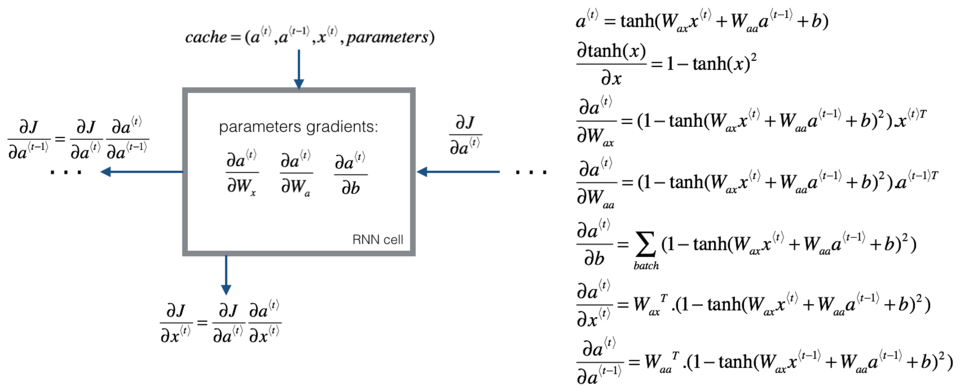

<center>图5：RNN单元的反向传播</center>
    
② 就像在全连接的神经网络中一样，损失函数$J$的导数遵循链规则在RNN中计算反向传播。链规则还用于计算$(\frac{\partial J}{\partial W_{ax}},\frac{\partial J}{\partial W_{aa}},\frac{\partial J}{\partial b})$更新参数$(W_{ax}, W_{aa}, b_a)$。

## 4.2 反向求导函数

① 要计算rnn_cell_backward，你需要计算以下方程式。手工导出它们是一个很好的练习。

② tanh的导数为$1-\tanh(x)^2$。请注意：$\sec(x)^2 = 1 - \tanh(x)^2$

③ 同样，对于$\frac{ \partial a^{\langle t \rangle} } {\partial W_{ax}}, \frac{ \partial a^{\langle t \rangle} } {\partial W_{aa}},  \frac{ \partial a^{\langle t \rangle} } {\partial b}$，导数为$(1-\tanh(u)^2)du$。

④ 最后两个方程式也遵循相同的规则，并使用tanh导数导出。

⑤ 请注意，这种安排是为了获得相同的维度以方便匹配的。

In [10]:
def rnn_cell_backward(da_next, cache):
    """
    实现基本的RNN单元的单步反向传播
    
    参数：
        da_next -- 关于下一个隐藏状态的损失的梯度。
        cache -- 字典类型，rnn_step_forward()的输出
        
    返回：
        gradients -- 字典，包含了以下参数：
                        dx -- 输入数据的梯度，维度为(n_x, m)
                        da_prev -- 上一隐藏层的隐藏状态，维度为(n_a, m)
                        dWax -- 输入到隐藏状态的权重的梯度，维度为(n_a, n_x)
                        dWaa -- 隐藏状态到隐藏状态的权重的梯度，维度为(n_a, n_a)
                        dba -- 偏置向量的梯度，维度为(n_a, 1)
    """
    # 获取cache 的值
    a_next, a_prev, xt, parameters = cache
    
    # 从 parameters 中获取参数
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    # 计算tanh相对于a_next的梯度.
    dtanh = (1 - np.square(a_next)) * da_next
    
    # 计算关于Wax损失的梯度
    dxt = np.dot(Wax.T,dtanh)
    dWax = np.dot(dtanh, xt.T)
    
    # 计算关于Waa损失的梯度
    da_prev = np.dot(Waa.T,dtanh)
    dWaa = np.dot(dtanh, a_prev.T)
    
    # 计算关于b损失的梯度
    dba = np.sum(dtanh, keepdims=True, axis=-1)
    
    # 保存这些梯度到字典内
    gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}
    
    return gradients

In [11]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
Wax = np.random.randn(5,3)
Waa = np.random.randn(5,5)
Wya = np.random.randn(2,5)
b = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}

a_next, yt, cache = rnn_cell_forward(xt, a_prev, parameters)

da_next = np.random.randn(5,10)
gradients = rnn_cell_backward(da_next, cache)
print("gradients[\"dxt\"][1][2] =", gradients["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients["da_prev"].shape)
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients["dba"][4])
print("gradients[\"dba\"].shape =", gradients["dba"].shape)

gradients["dxt"][1][2] = -0.4605641030588796
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = 0.08429686538067671
gradients["da_prev"].shape = (5, 10)
gradients["dWax"][3][1] = 0.3930818739219304
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = -0.2848395578696066
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [0.80517166]
gradients["dba"].shape = (5, 1)


## 4.3 反向传播封装

① 在每个时间步长$t$上计算相对于$a^{\langle t \rangle}$的损失梯度非常有用，因为它有助于将梯度反向传播到先前的RNN单元。

② 为此，你需要从头开始遍历所有时间步，并且在每一步中，增加总的$db_a$，$dW_{aa}$，$dW_{ax}$并存储$dx$。

③ 实现rnn_backward函数。首先用零初始化返回变量，然后循环遍历所有时间步，同时在每个时间步调用rnn_cell_backward，相应地更新其他变量。

In [12]:
def rnn_backward(da, caches):
    """
    在整个输入数据序列上实现RNN的反向传播
    
    参数：
        da -- 所有隐藏状态的梯度，维度为(n_a, m, T_x)
        caches -- 包含向前传播的信息的元组
    
    返回：    
        gradients -- 包含了梯度的字典：
                        dx -- 关于输入数据的梯度，维度为(n_x, m, T_x)
                        da0 -- 关于初始化隐藏状态的梯度，维度为(n_a, m)
                        dWax -- 关于输入权重的梯度，维度为(n_a, n_x)
                        dWaa -- 关于隐藏状态的权值的梯度，维度为(n_a, n_a)
                        dba -- 关于偏置的梯度，维度为(n_a, 1)
    """
    # 从caches中获取第一个cache（t=1）的值
    caches, x = caches
    a1, a0, x1, parameters = caches[0]
    
    # 获取da与x1的维度信息
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # 初始化梯度
    dx = np.zeros([n_x, m, T_x])
    dWax = np.zeros([n_a, n_x])
    dWaa = np.zeros([n_a, n_a])
    dba = np.zeros([n_a, 1])
    da0 = np.zeros([n_a, m])
    da_prevt = np.zeros([n_a, m])
    
    # 处理所有时间步
    for t in reversed(range(T_x)):
        # 计算时间步“t”时的梯度
        gradients = rnn_cell_backward(da[:, :, t] + da_prevt, caches[t])
        
        #从梯度中获取导数
        dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], gradients["dWax"], gradients["dWaa"], gradients["dba"]
        
        # 通过在时间步t添加它们的导数来增加关于全局导数的参数
        dx[:, :, t] = dxt
        dWax += dWaxt
        dWaa += dWaat
        dba += dbat
        
    #将 da0设置为a的梯度，该梯度已通过所有时间步骤进行反向传播
    da0 = da_prevt
    
    #保存这些梯度到字典内
    gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}
    
    return gradients

In [13]:
np.random.seed(1)
x = np.random.randn(3,10,4)
a0 = np.random.randn(5,10)
Wax = np.random.randn(5,3)
Waa = np.random.randn(5,5)
Wya = np.random.randn(2,5)
ba = np.random.randn(5,1)
by = np.random.randn(2,1)
parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "ba": ba, "by": by}
a, y, caches = rnn_forward(x, a0, parameters)
da = np.random.randn(5, 10, 4)
gradients = rnn_backward(da, caches)

print("gradients[\"dx\"][1][2] =", gradients["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients["da0"].shape)
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWax\"].shape =", gradients["dWax"].shape)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWaa\"].shape =", gradients["dWaa"].shape)
print("gradients[\"dba\"][4] =", gradients["dba"][4])
print("gradients[\"dba\"].shape =", gradients["dba"].shape)

gradients["dx"][1][2] = [-2.07101689 -0.59255627  0.02466855  0.01483317]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.3149423751266499
gradients["da0"].shape = (5, 10)
gradients["dWax"][3][1] = 11.264104496527777
gradients["dWax"].shape = (5, 3)
gradients["dWaa"][1][2] = 2.3033331265798926
gradients["dWaa"].shape = (5, 5)
gradients["dba"][4] = [-0.74747722]
gradients["dba"].shape = (5, 1)


# 5. 长短期记忆网络的反向传播

① LSTM反向传播比正向传播要复杂得多。

② 我们在下面为你提供了LSTM反向传播的所有方程式。
 - 如果你喜欢微积分练习，可以尝试从头开始自己演算。

## 5.1 门求导公式

$$d \Gamma_o^{\langle t \rangle} = da_{next}*\tanh(c_{next}) * \Gamma_o^{\langle t \rangle}*(1-\Gamma_o^{\langle t \rangle})\tag{7}$$

$$d\tilde c^{\langle t \rangle} = dc_{next}*\Gamma_i^{\langle t \rangle}+ \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * i_t * da_{next} * \tilde c^{\langle t \rangle} * (1-\tanh(\tilde c)^2) \tag{8}$$

$$d\Gamma_u^{\langle t \rangle} = dc_{next}*\tilde c^{\langle t \rangle} + \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * \tilde c^{\langle t \rangle} * da_{next}*\Gamma_u^{\langle t \rangle}*(1-\Gamma_u^{\langle t \rangle})\tag{9}$$

$$d\Gamma_f^{\langle t \rangle} = dc_{next}*\tilde c_{prev} + \Gamma_o^{\langle t \rangle} (1-\tanh(c_{next})^2) * c_{prev} * da_{next}*\Gamma_f^{\langle t \rangle}*(1-\Gamma_f^{\langle t \rangle})\tag{10}$$

## 5.2 反向求导函数

$$dW_f = d\Gamma_f^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{11}$$

$$dW_u = d\Gamma_u^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{12}$$

$$dW_c = d\tilde c^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{13}$$

$$dW_o = d\Gamma_o^{\langle t \rangle} * \begin{pmatrix} a_{prev} \\ x_t\end{pmatrix}^T \tag{14}$$

① 要计算$db_f, db_u, db_c, db_o$，你只需要在$d\Gamma_f^{\langle t \rangle}, d\Gamma_u^{\langle t \rangle}, d\tilde c^{\langle t \rangle}, d\Gamma_o^{\langle t \rangle}$的水平（axis=1）轴上分别求和。

② 注意，你应该有keep_dims = True选项。

③ 最后，你将针对先前的隐藏状态，先前的记忆状态和输入计算导数。

$$da_{prev} = W_f^T*d\Gamma_f^{\langle t \rangle} + W_u^T * d\Gamma_u^{\langle t \rangle}+ W_c^T * d\tilde c^{\langle t \rangle} + W_o^T * d\Gamma_o^{\langle t \rangle} \tag{15}$$

$$dx^{\langle t \rangle} = W_f^T*d\Gamma_f^{\langle t \rangle} + W_u^T * d\Gamma_u^{\langle t \rangle}+ W_c^T * d\tilde c_t + W_o^T * d\Gamma_o^{\langle t \rangle}\tag{17}$$

④ 其中等式15的权重是从$n_a$到末尾（即$W_f = W_f[n_a:,:]$ etc...）
 
⑤ lstm_cell_backward实现等式（7-17）。祝好运！

In [14]:
def lstm_cell_backward(da_next, dc_next, cache):
    """
    实现LSTM的单步反向传播
    
    参数：
        da_next -- 下一个隐藏状态的梯度，维度为(n_a, m)
        dc_next -- 下一个单元状态的梯度，维度为(n_a, m)
        cache -- 来自前向传播的一些参数
        
    返回：
        gradients -- 包含了梯度信息的字典：
                        dxt -- 输入数据的梯度，维度为(n_x, m)
                        da_prev -- 先前的隐藏状态的梯度，维度为(n_a, m)
                        dc_prev -- 前的记忆状态的梯度，维度为(n_a, m, T_x)
                        dWf -- 遗忘门的权值的梯度，维度为(n_a, n_a + n_x)
                        dbf -- 遗忘门的偏置的梯度，维度为(n_a, 1)
                        dWi -- 更新门的权值的梯度，维度为(n_a, n_a + n_x)
                        dbi -- 更新门的偏置的梯度，维度为(n_a, 1)
                        dWc -- 第一个“tanh”的权值的梯度，维度为(n_a, n_a + n_x)
                        dbc -- 第一个“tanh”的偏置的梯度，维度为(n_a, n_a + n_x)
                        dWo -- 输出门的权值的梯度，维度为(n_a, n_a + n_x)
                        dbo -- 输出门的偏置的梯度，维度为(n_a, 1)
    """
    # 从cache中获取信息
    (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache
    
    # 获取xt与a_next的维度信息
    n_x, m = xt.shape
    n_a, m = a_next.shape
    
    # 根据公式7-10来计算门的导数
    dot = da_next * np.tanh(c_next) * ot * (1 - ot)
    dcct = (dc_next * it + ot * (1 - np.square(np.tanh(c_next))) * it * da_next) * (1 - np.square(cct))
    dit = (dc_next * cct + ot * (1 - np.square(np.tanh(c_next))) * cct * da_next) * it * (1 - it)
    dft = (dc_next * c_prev + ot * (1 - np.square(np.tanh(c_next))) * c_prev * da_next) * ft * (1 - ft)
    
    # 根据公式11-14计算参数的导数
    concat = np.concatenate((a_prev, xt), axis=0).T
    dWf = np.dot(dft, concat)
    dWi = np.dot(dit, concat)
    dWc = np.dot(dcct, concat)
    dWo = np.dot(dot, concat)
    dbf = np.sum(dft,axis=1,keepdims=True)
    dbi = np.sum(dit,axis=1,keepdims=True)
    dbc = np.sum(dcct,axis=1,keepdims=True)
    dbo = np.sum(dot,axis=1,keepdims=True)
    
    
    # 使用公式15-17计算洗起来了隐藏状态、先前记忆状态、输入的导数。
    da_prev = np.dot(parameters["Wf"][:, :n_a].T, dft) + np.dot(parameters["Wc"][:, :n_a].T, dcct) +  np.dot(parameters["Wi"][:, :n_a].T, dit) + np.dot(parameters["Wo"][:, :n_a].T, dot)
        
    dc_prev = dc_next * ft + ot * (1 - np.square(np.tanh(c_next))) * ft * da_next
    
    dxt = np.dot(parameters["Wf"][:, n_a:].T, dft) + np.dot(parameters["Wc"][:, n_a:].T, dcct) +  np.dot(parameters["Wi"][:, n_a:].T, dit) + np.dot(parameters["Wo"][:, n_a:].T, dot)
    
    # 保存梯度信息到字典
    gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}
    
    return gradients

In [15]:
np.random.seed(1)
xt = np.random.randn(3,10)
a_prev = np.random.randn(5,10)
c_prev = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)
Wy = np.random.randn(2,5)
by = np.random.randn(2,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a_next, c_next, yt, cache = lstm_cell_forward(xt, a_prev, c_prev, parameters)

da_next = np.random.randn(5,10)
dc_next = np.random.randn(5,10)
gradients = lstm_cell_backward(da_next, dc_next, cache)
print("gradients[\"dxt\"][1][2] =", gradients["dxt"][1][2])
print("gradients[\"dxt\"].shape =", gradients["dxt"].shape)
print("gradients[\"da_prev\"][2][3] =", gradients["da_prev"][2][3])
print("gradients[\"da_prev\"].shape =", gradients["da_prev"].shape)
print("gradients[\"dc_prev\"][2][3] =", gradients["dc_prev"][2][3])
print("gradients[\"dc_prev\"].shape =", gradients["dc_prev"].shape)
print("gradients[\"dWf\"][3][1] =", gradients["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients["dbo"].shape)

gradients["dxt"][1][2] = 3.2305591151091884
gradients["dxt"].shape = (3, 10)
gradients["da_prev"][2][3] = -0.06396214197109239
gradients["da_prev"].shape = (5, 10)
gradients["dc_prev"][2][3] = 0.7975220387970015
gradients["dc_prev"].shape = (5, 10)
gradients["dWf"][3][1] = -0.14795483816449725
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 1.0574980552259903
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = 2.3045621636876668
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.3313115952892108
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [0.18864637]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.40142491]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [0.25587763]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [0.13893342]
gradients["dbo"].shape = (5, 1)


## 5.3 反向传播封装

① 这部分与我们在上面实现的rnn_backward函数非常相似。

② 我们将首先创建与返回变量相同维度的变量。然后将遍历从结束到开始的所有时间步，并调用在每次迭代时为LSTM实现的单步反向传播功能。然后我们将通过单独求和来更新参数，最后返回一个带有新梯度的字典。

③ 下面实现lstm_backward函数。创建一个从$T_x$开始并向后的for循环。
 - 对于每个步骤，请调用lstm_cell_backward并通过向其添加新梯度来更新旧梯度。
 - 请注意，dxt不会更新而是存储。

In [16]:
def lstm_backward(da, caches):
    
    """
    实现LSTM网络的反向传播
    
    参数：
        da -- 关于隐藏状态的梯度，维度为(n_a, m, T_x)
        cachses -- 前向传播保存的信息
    
    返回：
        gradients -- 包含了梯度信息的字典：
                        dx -- 输入数据的梯度，维度为(n_x, m，T_x)
                        da0 -- 先前的隐藏状态的梯度，维度为(n_a, m)
                        dWf -- 遗忘门的权值的梯度，维度为(n_a, n_a + n_x)
                        dbf -- 遗忘门的偏置的梯度，维度为(n_a, 1)
                        dWi -- 更新门的权值的梯度，维度为(n_a, n_a + n_x)
                        dbi -- 更新门的偏置的梯度，维度为(n_a, 1)
                        dWc -- 第一个“tanh”的权值的梯度，维度为(n_a, n_a + n_x)
                        dbc -- 第一个“tanh”的偏置的梯度，维度为(n_a, n_a + n_x)
                        dWo -- 输出门的权值的梯度，维度为(n_a, n_a + n_x)
                        dbo -- 输出门的偏置的梯度，维度为(n_a, 1)
        
    """

    # 从caches中获取第一个cache（t=1）的值
    caches, x = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]
    
    # 获取da与x1的维度信息
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # 初始化梯度
    dx = np.zeros([n_x, m, T_x])
    da0 = np.zeros([n_a, m])
    da_prevt = np.zeros([n_a, m])
    dc_prevt = np.zeros([n_a, m])
    dWf = np.zeros([n_a, n_a + n_x])
    dWi = np.zeros([n_a, n_a + n_x])
    dWc = np.zeros([n_a, n_a + n_x])
    dWo = np.zeros([n_a, n_a + n_x])
    dbf = np.zeros([n_a, 1])
    dbi = np.zeros([n_a, 1])
    dbc = np.zeros([n_a, 1])
    dbo = np.zeros([n_a, 1])
    
    # 处理所有时间步
    for t in reversed(range(T_x)):
        # 使用lstm_cell_backward函数计算所有梯度
        gradients = lstm_cell_backward(da[:,:,t],dc_prevt,caches[t])
        # 保存相关参数
        dx[:,:,t] = gradients['dxt']
        dWf = dWf+gradients['dWf']
        dWi = dWi+gradients['dWi']
        dWc = dWc+gradients['dWc']
        dWo = dWo+gradients['dWo']
        dbf = dbf+gradients['dbf']
        dbi = dbi+gradients['dbi']
        dbc = dbc+gradients['dbc']
        dbo = dbo+gradients['dbo']
    # 将第一个激活的梯度设置为反向传播的梯度da_prev。
    da0 = gradients['da_prev']

    # 保存所有梯度到字典变量内
    gradients = {"dx": dx, "da0": da0, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}
    
    return gradients

In [17]:
np.random.seed(1)
x = np.random.randn(3,10,7)
a0 = np.random.randn(5,10)
Wf = np.random.randn(5, 5+3)
bf = np.random.randn(5,1)
Wi = np.random.randn(5, 5+3)
bi = np.random.randn(5,1)
Wo = np.random.randn(5, 5+3)
bo = np.random.randn(5,1)
Wc = np.random.randn(5, 5+3)
bc = np.random.randn(5,1)

parameters = {"Wf": Wf, "Wi": Wi, "Wo": Wo, "Wc": Wc, "Wy": Wy, "bf": bf, "bi": bi, "bo": bo, "bc": bc, "by": by}

a, y, c, caches = lstm_forward(x, a0, parameters)

da = np.random.randn(5, 10, 4)
gradients = lstm_backward(da, caches)

print("gradients[\"dx\"][1][2] =", gradients["dx"][1][2])
print("gradients[\"dx\"].shape =", gradients["dx"].shape)
print("gradients[\"da0\"][2][3] =", gradients["da0"][2][3])
print("gradients[\"da0\"].shape =", gradients["da0"].shape)
print("gradients[\"dWf\"][3][1] =", gradients["dWf"][3][1])
print("gradients[\"dWf\"].shape =", gradients["dWf"].shape)
print("gradients[\"dWi\"][1][2] =", gradients["dWi"][1][2])
print("gradients[\"dWi\"].shape =", gradients["dWi"].shape)
print("gradients[\"dWc\"][3][1] =", gradients["dWc"][3][1])
print("gradients[\"dWc\"].shape =", gradients["dWc"].shape)
print("gradients[\"dWo\"][1][2] =", gradients["dWo"][1][2])
print("gradients[\"dWo\"].shape =", gradients["dWo"].shape)
print("gradients[\"dbf\"][4] =", gradients["dbf"][4])
print("gradients[\"dbf\"].shape =", gradients["dbf"].shape)
print("gradients[\"dbi\"][4] =", gradients["dbi"][4])
print("gradients[\"dbi\"].shape =", gradients["dbi"].shape)
print("gradients[\"dbc\"][4] =", gradients["dbc"][4])
print("gradients[\"dbc\"].shape =", gradients["dbc"].shape)
print("gradients[\"dbo\"][4] =", gradients["dbo"][4])
print("gradients[\"dbo\"].shape =", gradients["dbo"].shape)

gradients["dx"][1][2] = [-0.00173313  0.08287442 -0.30545663 -0.43281115]
gradients["dx"].shape = (3, 10, 4)
gradients["da0"][2][3] = -0.09591150195400472
gradients["da0"].shape = (5, 10)
gradients["dWf"][3][1] = -0.06981985612744011
gradients["dWf"].shape = (5, 8)
gradients["dWi"][1][2] = 0.10237182024854774
gradients["dWi"].shape = (5, 8)
gradients["dWc"][3][1] = -0.062498379492745254
gradients["dWc"].shape = (5, 8)
gradients["dWo"][1][2] = 0.04843891314443011
gradients["dWo"].shape = (5, 8)
gradients["dbf"][4] = [-0.0565788]
gradients["dbf"].shape = (5, 1)
gradients["dbi"][4] = [-0.15399065]
gradients["dbi"].shape = (5, 1)
gradients["dbc"][4] = [-0.29691142]
gradients["dbc"].shape = (5, 1)
gradients["dbo"][4] = [-0.29798344]
gradients["dbo"].shape = (5, 1)
